In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import pandas as pd
from matplotlib import pyplot as plt
from shapely import wkt
from geopandas import GeoDataFrame
import matplotlib.patches as mpatches
%matplotlib inline

plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.labelsize'] = 12

In [2]:
CABA = gpd.read_file('datos/mapas/barrios.shp')
CABA.head()

,BARRIO,COMUNA,PERIMETRO,AREA,geometry
0,CHACARITA,15.0,7725.695228,3.118101e+06,"POLYGON ((-58.4528200492791 -34.5959886570639,..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,"POLYGON ((-58.4655768128541 -34.5965577078058,..."
2,VILLA CRESPO,15.0,8132.699348,3.613584e+06,"POLYGON ((-58.4237529813037 -34.5978273383243,..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,"POLYGON ((-58.4946097568899 -34.6148652395239,..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,"POLYGON ((-58.4128700313089 -34.6141162515854,..."


In [3]:
# La mantengo por las dudas pero no  creo que sea necesaria

def obtener_poligono(multi):
    l =[]
    for x in multi.split(')'):
        poligono = []
        for y in x.split(','):
            if 'MULTIPOLYGON ' in y:
                y = y.replace('MULTIPOLYGON ', '')
            if 'POLYGON ' in y:
                y = y.replace('POLYGON ', '')
            if '(' in y:
                y = y.replace('(', '')
            if len(y) < 5:
                continue
            lon, lat = y.split()
            poligono.append((float(lon), float(lat)))
        l.append(Polygon(poligono))
    return MultiPolygon(l)

In [3]:
propiedades = pd.read_csv('/home/mati/Desktop/properati.csv')
#propiedades = pd.read_csv('/home/agustin/Escritorio/escritorio/fiuba/Organizacion de datos/properati.csv')

In [4]:
solo_capital = propiedades.loc[(propiedades.state_name == 'Capital Federal') \
                               & (propiedades.lat.notnull()) & (propiedades.lon.notnull()),:]

# Mapas segun precios promedios

In [7]:
def eliminar_acentos(string):
    con_tilde = ['á','é', 'í', 'ó', 'ú']
    sin_tilde = ['a', 'e', 'i', 'o', 'u']
    res = ''
    for c in string:
        if c.lower() in con_tilde:
            i = con_tilde.index(c.lower())
            c = sin_tilde[i].upper()
        res += c
    return res

In [8]:
solo_capital.loc[:,'place_name'] = solo_capital.loc[:,'place_name'].str.upper()
solo_capital.loc[:,'place_name'] = solo_capital.loc[:,'place_name'].apply(eliminar_acentos)

/home/mati/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
solo_capital = solo_capital.loc[:,['place_name','price_aprox_usd','price_usd_per_m2']].\
groupby('place_name').agg('mean')
solo_capital.head()

,price_aprox_usd,price_usd_per_m2
place_name,,
ABASTO,179523.577760,2190.649905
AGRONOMIA,149832.852879,1894.759049
ALMAGRO,142561.157301,2184.704630
BALVANERA,145690.837541,2010.083238
BARRACAS,177610.845659,2034.991567


In [10]:
caba = pd.merge(CABA,solo_capital,how='left',left_on='BARRIO', right_index=True)
caba.head()

,BARRIO,COMUNA,PERIMETRO,AREA,geometry,price_aprox_usd,price_usd_per_m2
0,CHACARITA,15.0,7725.695228,3.118101e+06,"POLYGON ((-58.4528200492791 -34.5959886570639,...",163943.314730,2135.536814
1,PATERNAL,15.0,7087.513295,2.229829e+06,"POLYGON ((-58.4655768128541 -34.5965577078058,...",141183.156369,2045.190416
2,VILLA CRESPO,15.0,8132.699348,3.613584e+06,"POLYGON ((-58.4237529813037 -34.5978273383243,...",159825.480377,2455.153276
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,"POLYGON ((-58.4946097568899 -34.6148652395239,...",141712.094807,2296.124163
4,ALMAGRO,5.0,8537.901368,4.050752e+06,"POLYGON ((-58.4128700313089 -34.6141162515854,...",142561.157301,2184.704630


In [11]:
caba = caba.fillna(0)
caba.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
BARRIO              48 non-null object
COMUNA              48 non-null float64
PERIMETRO           48 non-null float64
AREA                48 non-null float64
geometry            48 non-null object
price_aprox_usd     48 non-null float64
price_usd_per_m2    48 non-null float64
dtypes: float64(5), object(2)
memory usage: 2.7+ KB


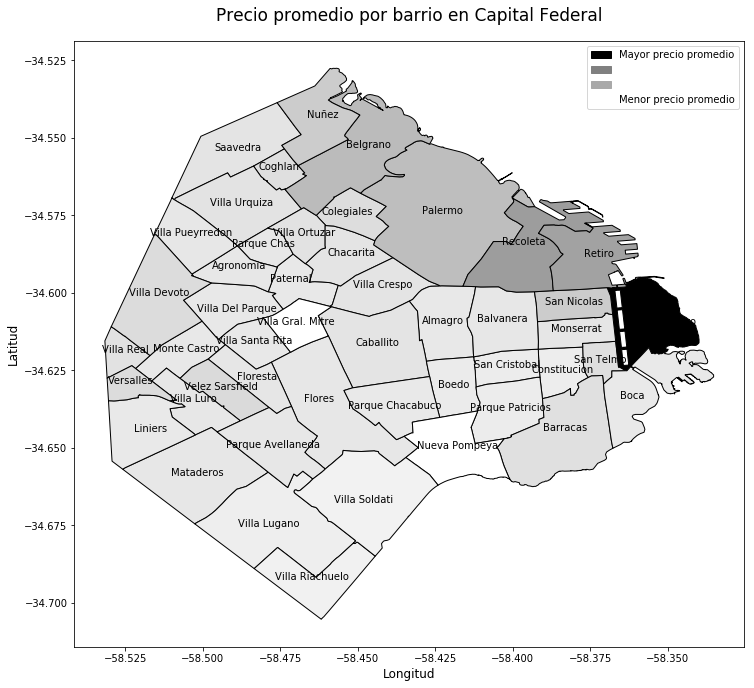

In [13]:
caba.BARRIO = caba.BARRIO.str.title()
plot = caba.plot(figsize = (12,12), column = 'price_aprox_usd', cmap='Greys',edgecolor = 'black');
caba['coords'] = caba['geometry'].apply(lambda x: x.representative_point().coords[:])
caba['coords'] = [coords[0] for coords in caba['coords']]
for idx, row in caba.iterrows():
    plt.annotate(s=row['BARRIO'], xy=row['coords'],horizontalalignment='center')
plot.set_title('Precio promedio por barrio en Capital Federal');
plot.set_xlabel("Longitud");
plot.set_ylabel("Latitud");

caro_label = mpatches.Patch(color='Black', label='Mayor precio promedio')
medio1 = mpatches.Patch(color='grey', label='')
medio2 = mpatches.Patch(color='darkgrey', label='')
barato_label = mpatches.Patch(color='white', label='Menor precio promedio')
plt.legend(handles=[caro_label,medio1, medio2, barato_label])


plt.savefig('informe/imagenes/mapa_promedio_precios_Capital.png', bbox_inches = 'tight', pad_inches = 0.5)

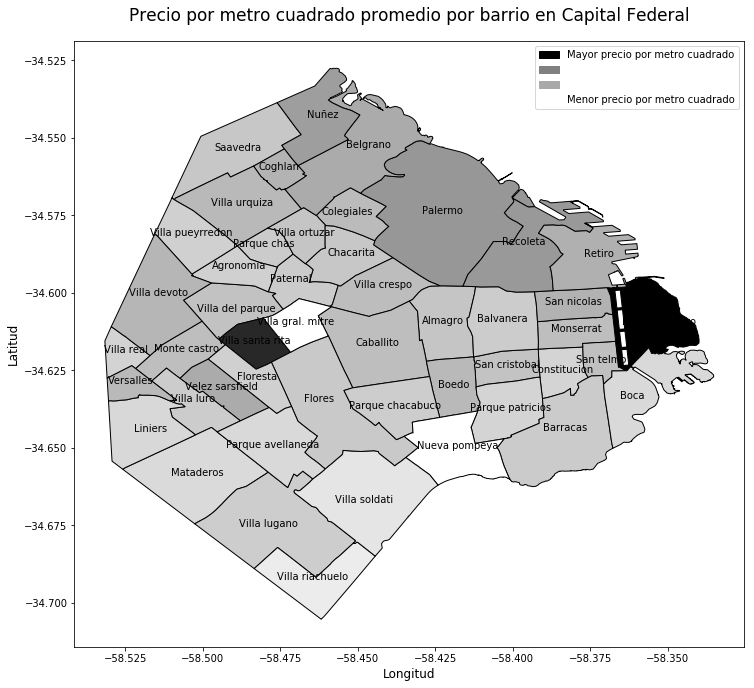

In [14]:
caba.BARRIO = caba.BARRIO.str.capitalize()
plot = caba.plot(figsize = (12,12), column = 'price_usd_per_m2', cmap='Greys',edgecolor = 'black')
caba['coords'] = caba['geometry'].apply(lambda x: x.representative_point().coords[:])
caba['coords'] = [coords[0] for coords in caba['coords']]
for idx, row in caba.iterrows():
    plt.annotate(s=row['BARRIO'], xy=row['coords'],horizontalalignment='center',)
plot.set_title('Precio por metro cuadrado promedio por barrio en Capital Federal');
plot.set_xlabel("Longitud");
plot.set_ylabel("Latitud");

caro_label = mpatches.Patch(color='Black', label='Mayor precio por metro cuadrado')
medio1 = mpatches.Patch(color='grey', label='')
medio2 = mpatches.Patch(color='darkgrey', label='')
barato_label = mpatches.Patch(color='white', label='Menor precio por metro cuadrado')
plt.legend(handles=[caro_label,medio1, medio2, barato_label])


plt.savefig('informe/imagenes/mapa_promedio_precios_m2_Capital.png', bbox_inches = 'tight', pad_inches = 0.5)